In [1]:
import os

from cedtrainscheduler.simulator.config import SimulatorConfig
from cedtrainscheduler.simulator.simulator import Simulator
from cedtrainscheduler.simulator.types import Metrics


def run_simulation(scheduler_name, fs_config_path, jobs_count, task_smaple_type):
    """运行模拟并返回结果"""
    current_dir = os.getcwd()  # 使用 os.getcwd() 获取当前工作目录
    base_dir = os.path.dirname(current_dir)


    config = SimulatorConfig(
        cluster_config_path=os.path.join(base_dir, "cedtrainscheduler/cases/cluster/cluster_config.json"),
        fs_config_path=os.path.join(base_dir, "cedtrainscheduler/cases/cluster/"+fs_config_path),
        scheduler_name=scheduler_name,
        task_config_path=os.path.join(base_dir, f"cedtrainscheduler/cases/task/case_{task_smaple_type}_{jobs_count}_tasks.csv"),
        output_path=os.path.join(base_dir, "examples/outputs"),
    )

    simulator = Simulator(config)
    results = simulator.simulation()
    return results


# 运行不同调度器的模拟
schedulers = ["fcfs-data", "fcfs", "sjf-data", "sjf", "dtsm", "sc-rm"]
jobs_count_list = [1000, 2000, 3000, 4000, 5000]
results_dict: dict[int, dict[str, Metrics]] = {}

for jobs_count in jobs_count_list:
    results_dict[jobs_count] = {}
    for scheduler in schedulers:
        results = run_simulation(scheduler, fs_config_path='fs_config.json', jobs_count=jobs_count, task_smaple_type="random")
        results_dict[jobs_count][scheduler] = results
        print(results)


Metrics(scheduler_name=<SchedulerType.FCFS_DATA: 1>, task_count=1000, total_runtime=1357151.7924563845, avg_queue_time=162217.2907381269, avg_running_time=177745.646738127, avg_execution_time=15528.356, cloud_count=344, edge_count=336, terminal_count=320)
Metrics(scheduler_name=<SchedulerType.FCFS: 2>, task_count=1000, total_runtime=596665.3388791173, avg_queue_time=86107.58386336407, avg_running_time=98672.11386336407, avg_execution_time=12564.53, cloud_count=702, edge_count=153, terminal_count=145)
Metrics(scheduler_name=<SchedulerType.SJF_DATA: 3>, task_count=1000, total_runtime=1264995.1753269949, avg_queue_time=107203.72213162713, avg_running_time=122301.30813162716, avg_execution_time=15097.586, cloud_count=340, edge_count=334, terminal_count=326)
Metrics(scheduler_name=<SchedulerType.SJF: 4>, task_count=1000, total_runtime=1701037.1460502753, avg_queue_time=44545.305665005224, avg_running_time=57662.390665005216, avg_execution_time=13117.085, cloud_count=817, edge_count=103, ter

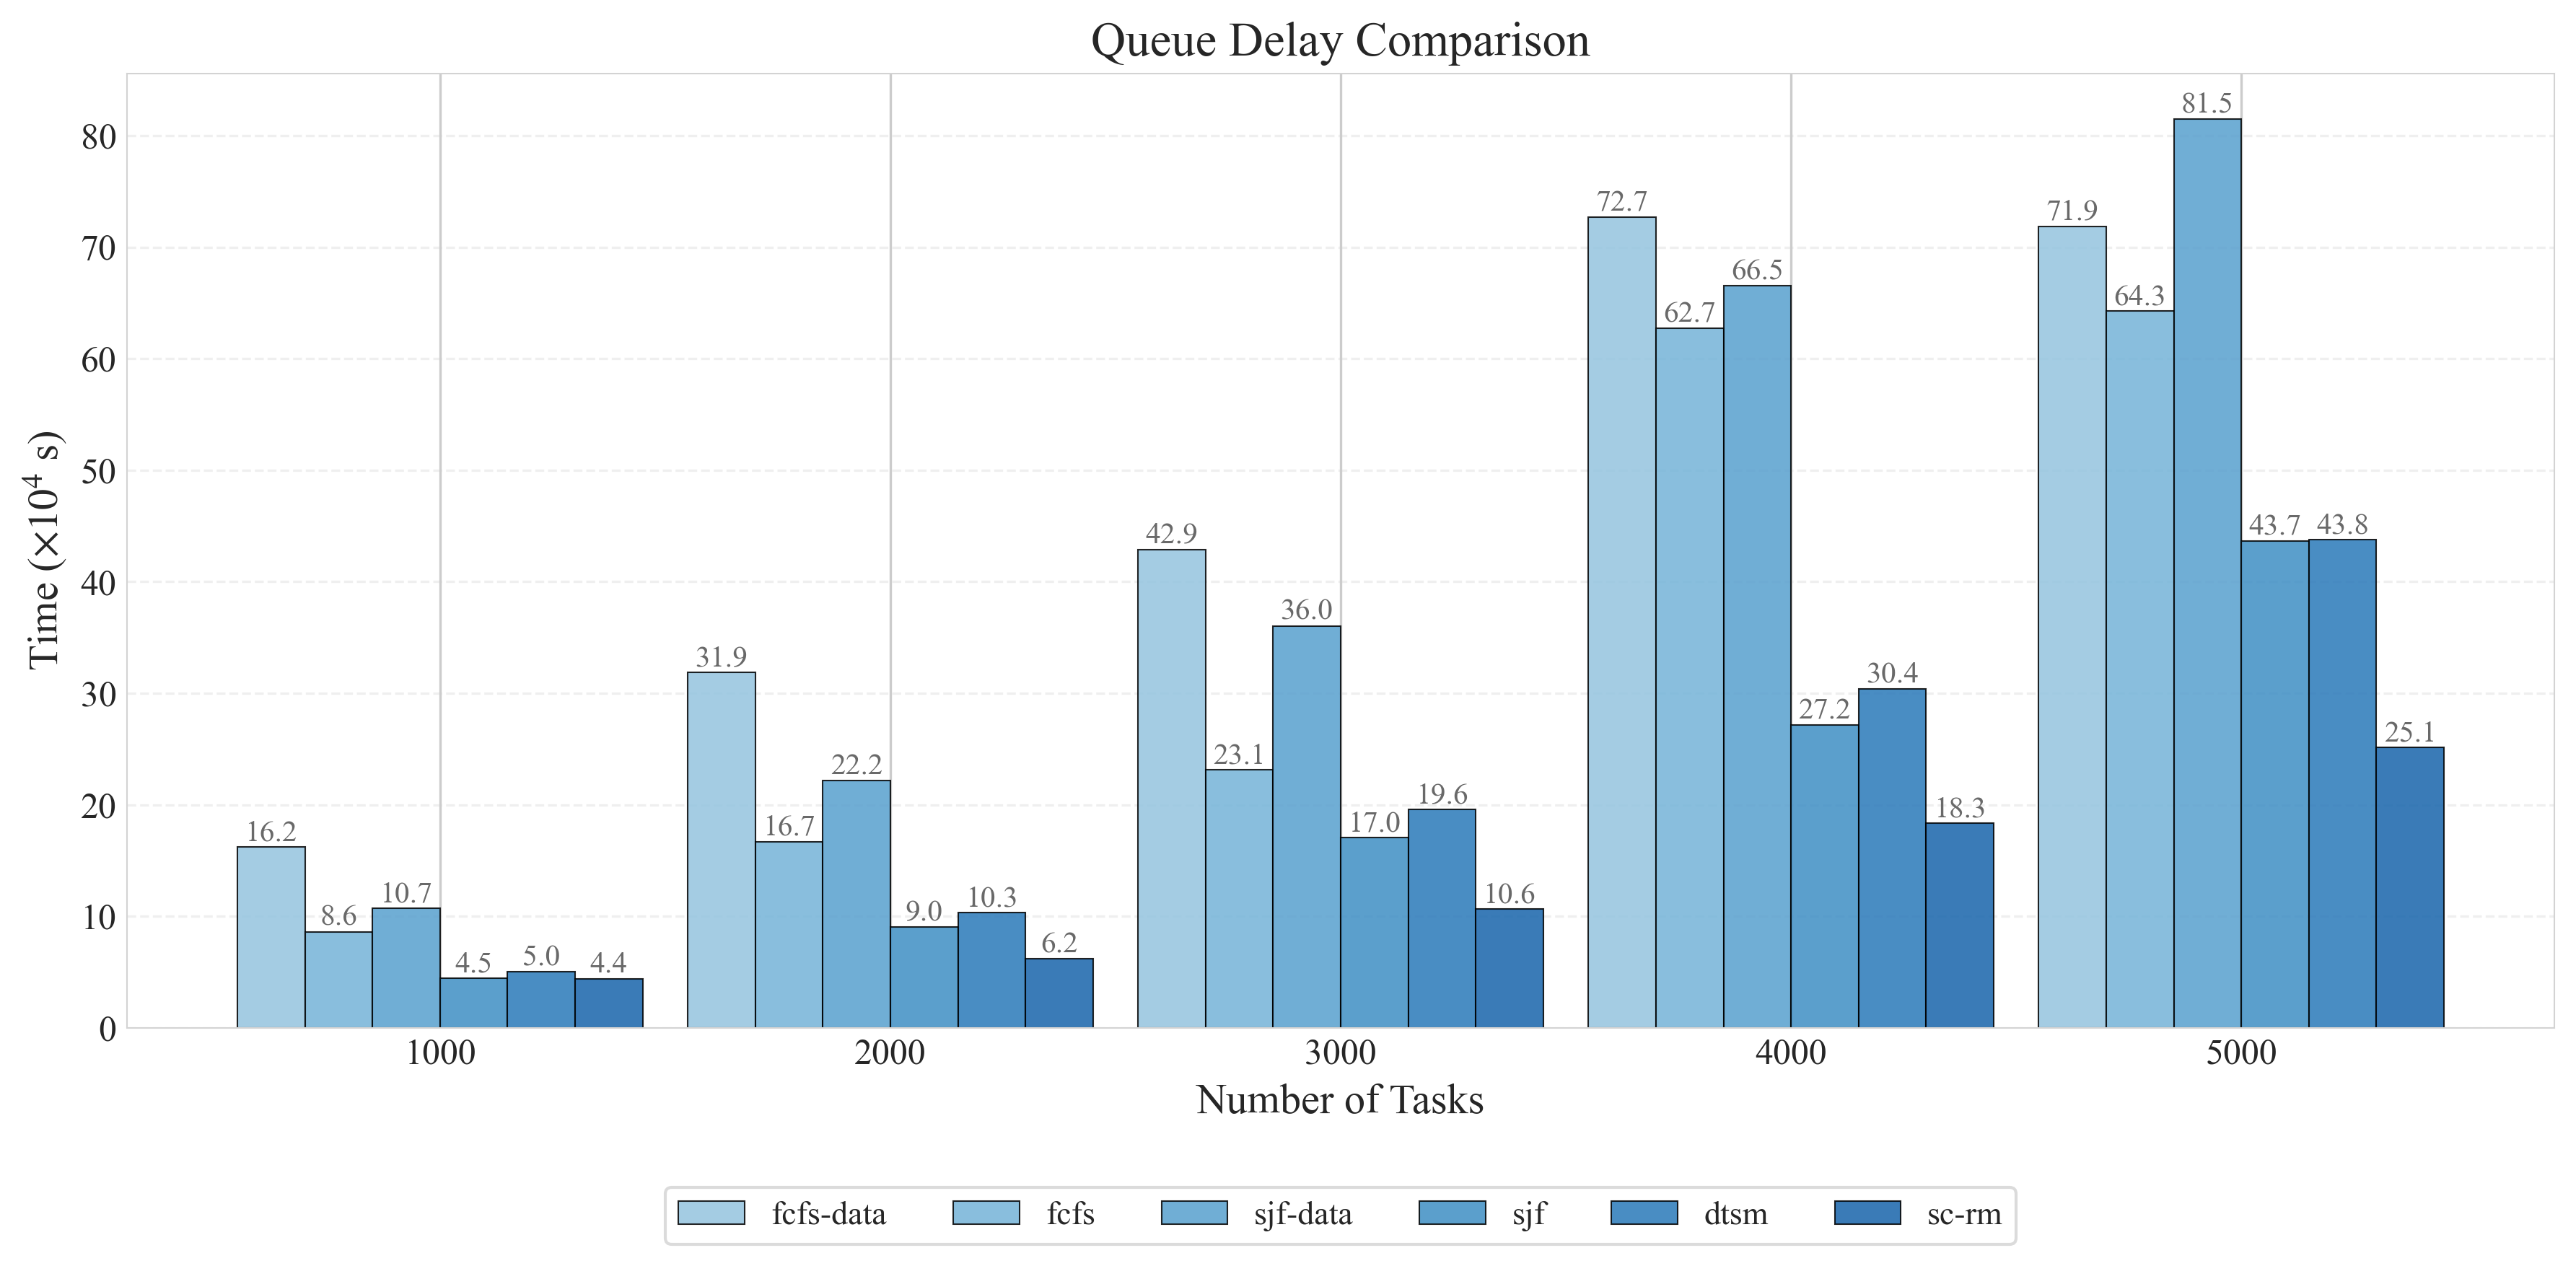

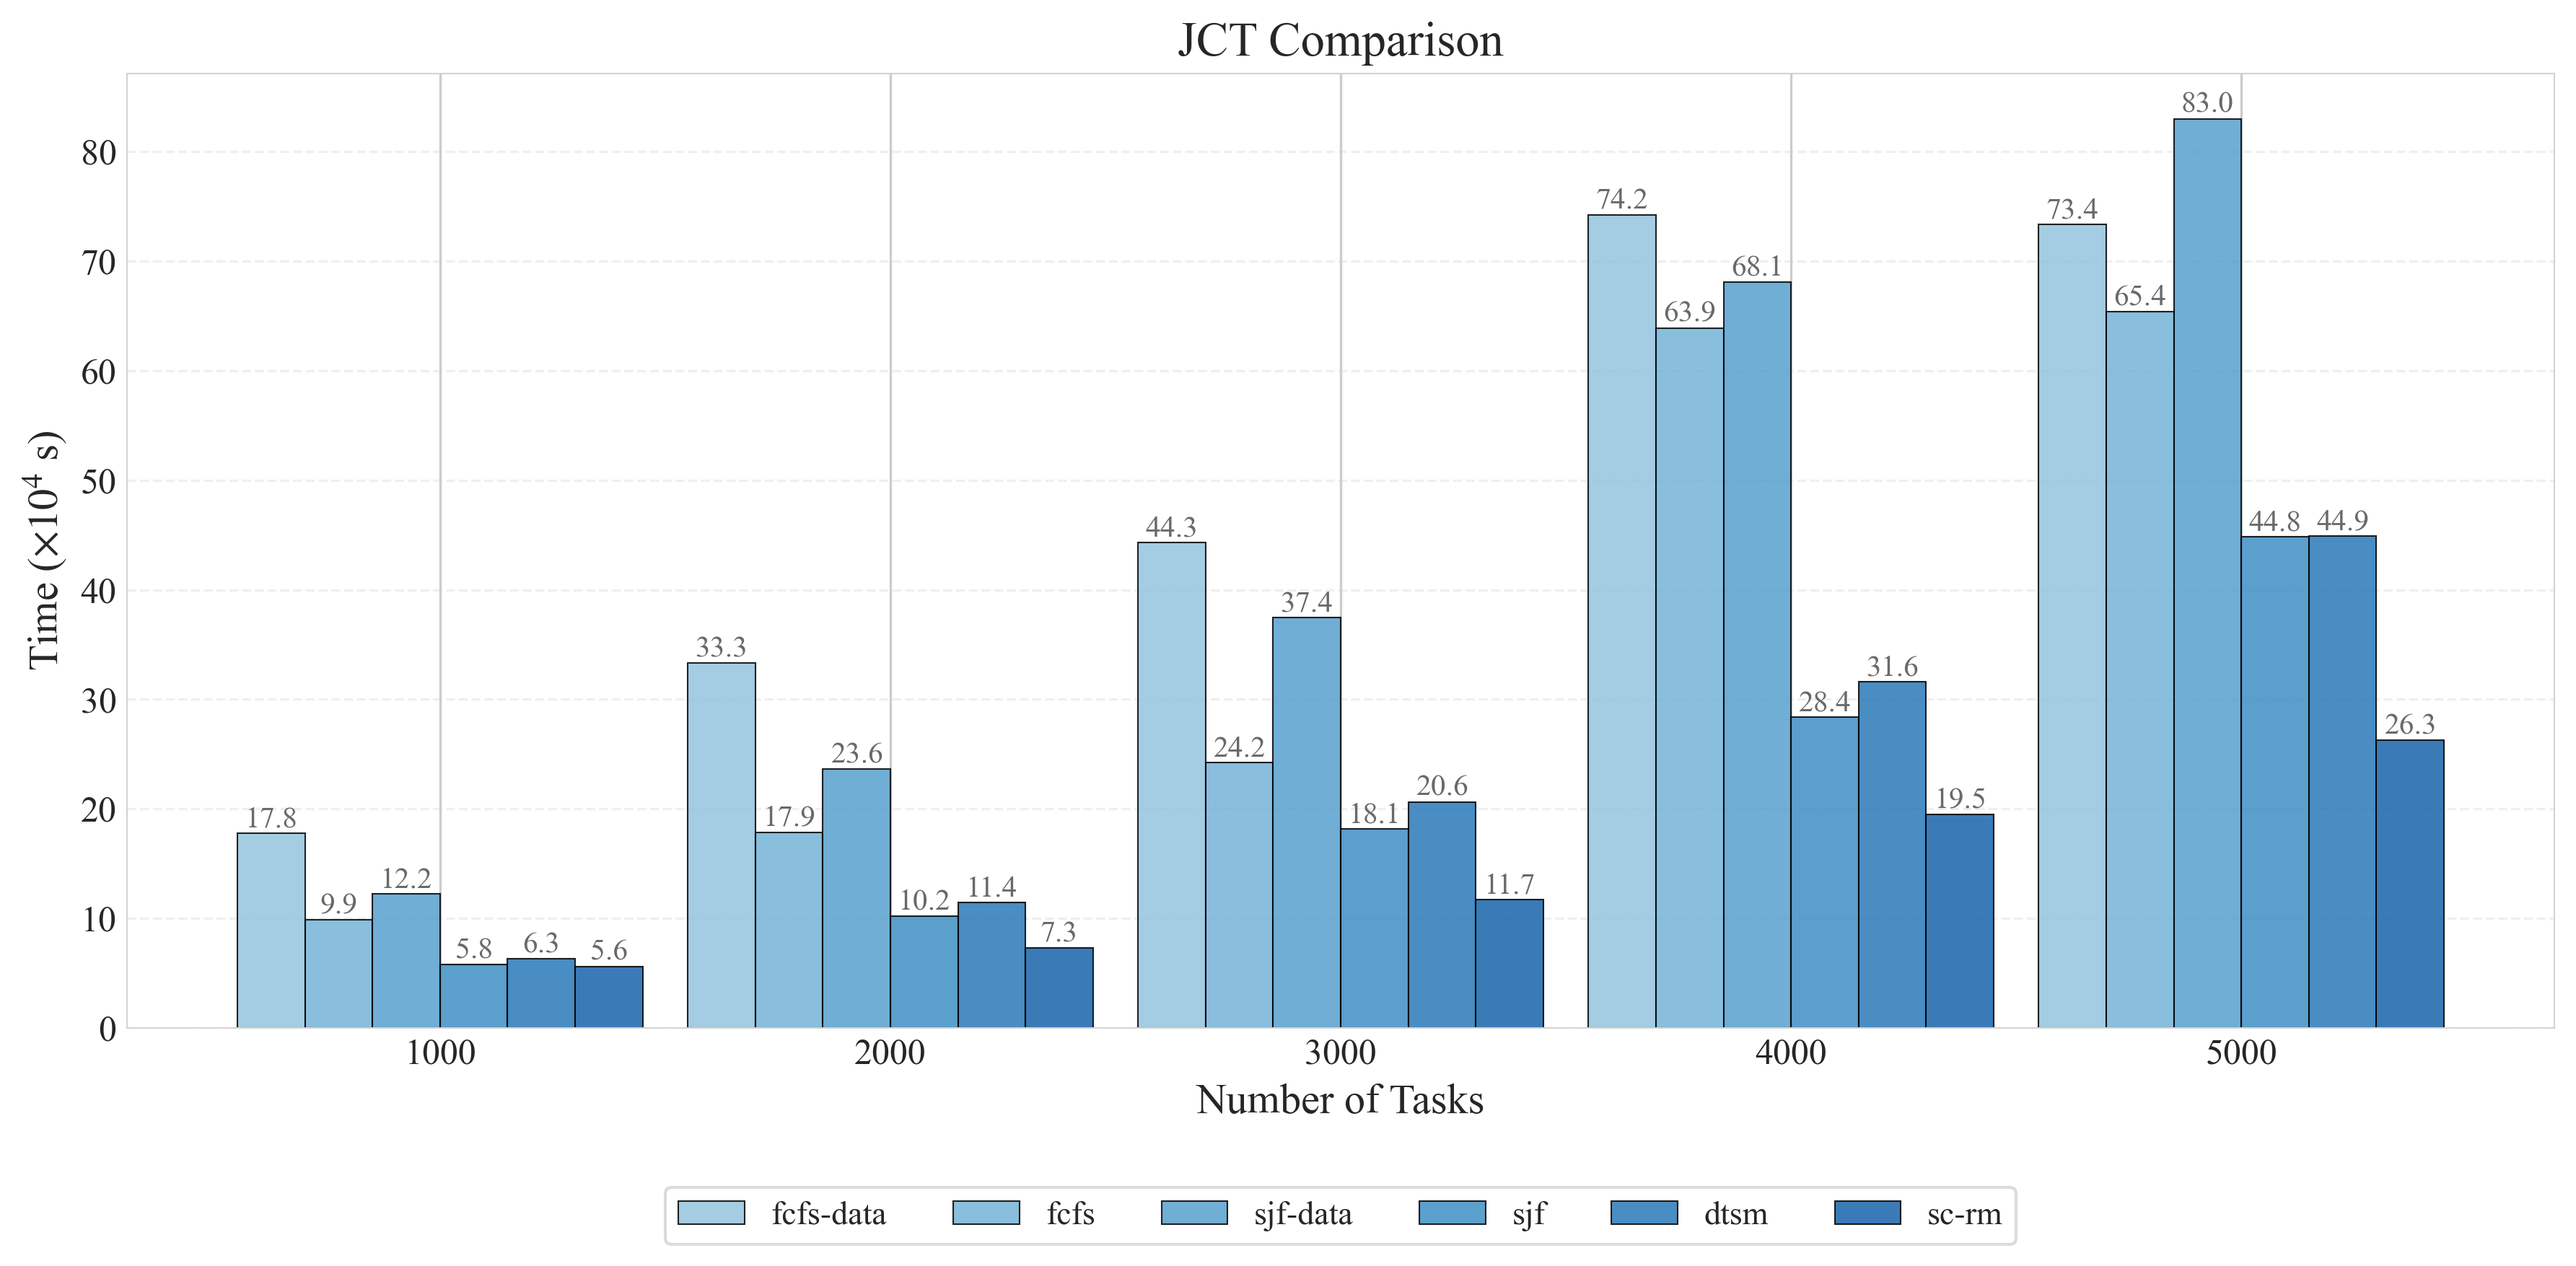

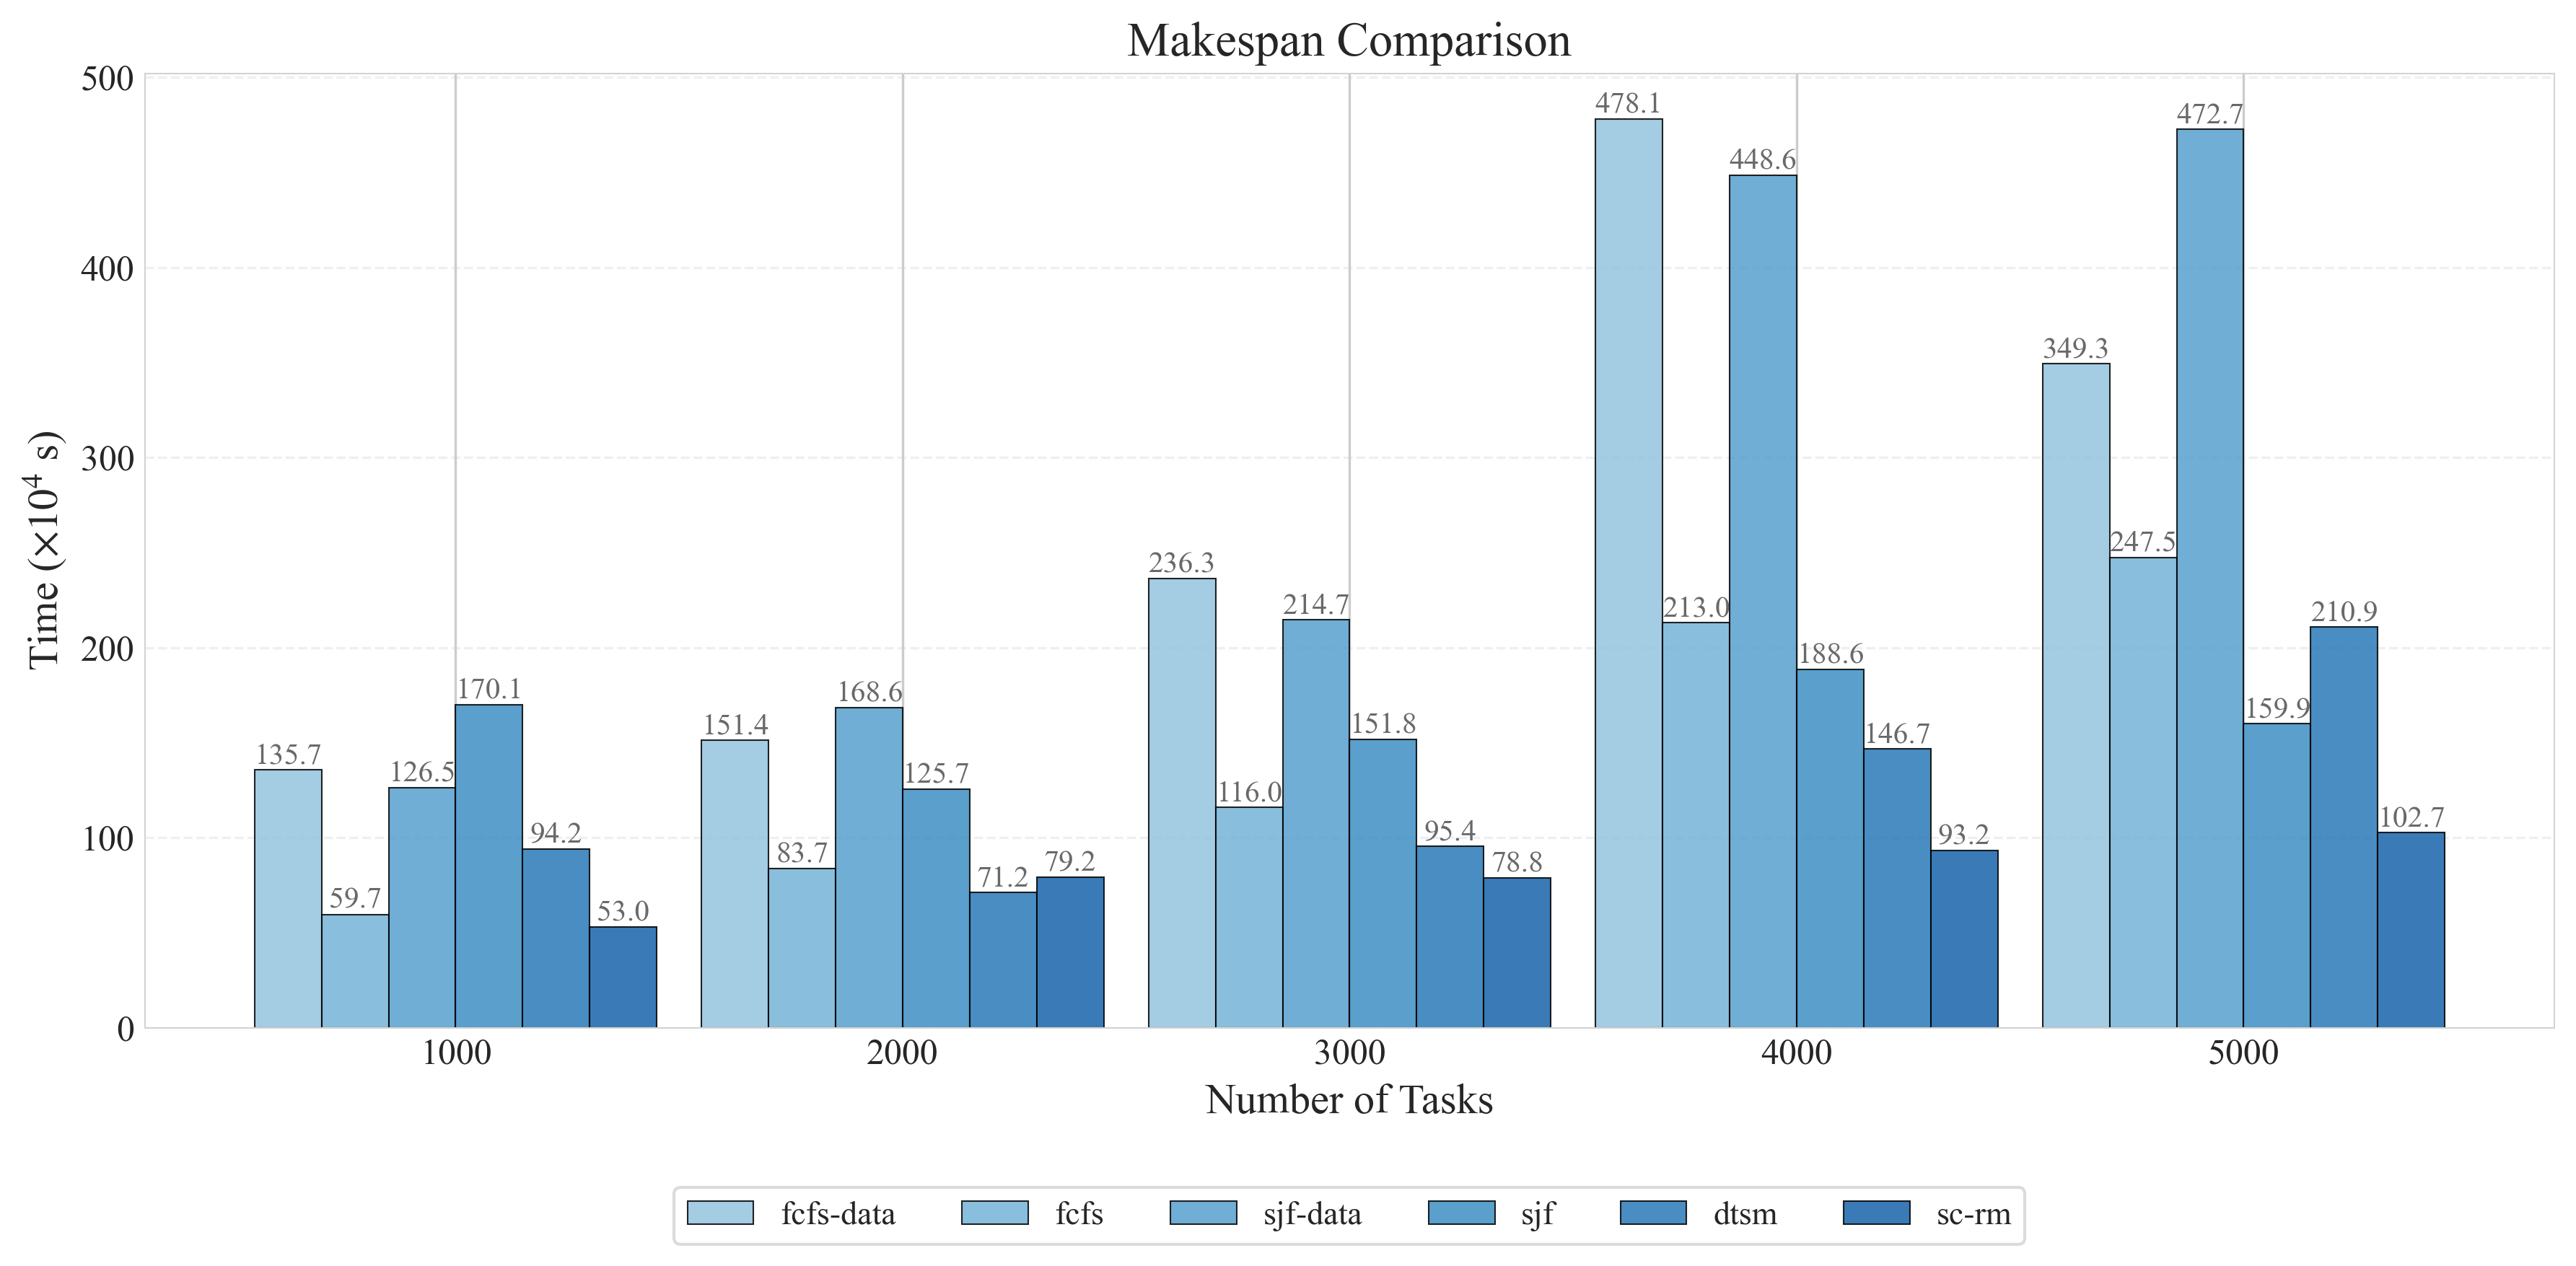

In [2]:
def plot_metrics_comparison(results_dict):
    """绘制不同任务数量下各调度器的性能比较柱状图"""
    import matplotlib.pyplot as plt
    import numpy as np

    # 设置绘图样式
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif', 'Palatino', 'serif'],
        'mathtext.fontset': 'stix',
        'axes.labelsize': 14,          # 从11增加到14
        'axes.titlesize': 16,          # 从12增加到16
        'xtick.labelsize': 12,         # 从10增加到12
        'ytick.labelsize': 12,         # 从10增加到12
        'legend.fontsize': 11,         # 从9增加到11
    })

    # 获取调度器列表和任务数量列表
    schedulers = list(results_dict[list(results_dict.keys())[0]].keys())
    jobs_counts = sorted(list(results_dict.keys()))  # 确保任务数量有序

    # 使用不同的颜色方案
    colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(schedulers)))

    # 设置柱状图的宽度
    width = 0.9 / len(schedulers)  # 根据调度器数量自动调整宽度
    
    # 指标列表
    metrics = [
        ('avg_queue_time', 'Queue Delay'),
        ('avg_running_time', 'JCT'),
        ('total_runtime', 'Makespan')
    ]

    # 为每个指标创建单独的图
    for metric_attr, metric_name in metrics:
        plt.figure(figsize=(12, 6), dpi=300)
        ax = plt.gca()
        
        # 为每个调度器绘制柱状图
        for scheduler_idx, scheduler in enumerate(schedulers):
            x_positions = np.arange(len(jobs_counts))
            values = [results_dict[jobs_count][scheduler].__getattribute__(metric_attr) for jobs_count in jobs_counts]
            
            # 计算柱子的位置
            x = x_positions + scheduler_idx * width - (len(schedulers) - 1) * width / 2
            
            # 绘制柱状图
            bars = ax.bar(x, [v/1e4 for v in values],
                         width,
                         label=scheduler,
                         color=colors[scheduler_idx],
                         edgecolor='black',
                         linewidth=0.5,
                         alpha=0.85)
            
            # 添加数据标签
            for i, v in enumerate(values):
                ax.text(x[i], v/1e4, f'{v/1e4:.1f}',
                       ha='center', va='bottom',
                       fontsize=10, color='dimgray')

        # 设置图表样式
        ax.set_title(f'{metric_name} Comparison')
        ax.set_xlabel('Number of Tasks')
        ax.set_ylabel('Time ($\\times 10^4$ s)')
        
        # 设置x轴刻度
        ax.set_xticks(x_positions)
        ax.set_xticklabels(jobs_counts)
        
        # 设置网格线
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        
        # 美化边框
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            spine.set_color('lightgray')

        # 添加图例
        plt.legend(bbox_to_anchor=(0.5, -0.15),
                  loc='upper center',
                  ncol=len(schedulers),
                  frameon=True,
                  edgecolor='lightgray')

        # 调整布局
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)
        
        plt.show()
        plt.close()

# 使用示例
plot_metrics_comparison(results_dict)

In [3]:
def calculate_metrics_reduction(results_dict):
    """计算CED策略相对于其他调度器的各项指标降低百分比
    
    Args:
        results_dict: 包含不同任务数量下各调度器结果的字典
        
    Returns:
        dict: 每个任务数量下各指标的降低百分比
    """
    metrics_reduction = {}
    
    # 遍历每个任务数量
    for job_count in results_dict.keys():
        metrics_reduction[job_count] = {
            'queue_delay': {},
            'jct': {},
            'makespan': {}
        }
        
        results = results_dict[job_count]
        
        # 获取CED的基准值
        ced_queue_delay = results['ced'].avg_queue_time
        ced_jct = results['ced'].avg_running_time
        ced_makespan = results['ced'].total_runtime
        
        # 计算相对于其他调度器的降低百分比
        for scheduler in results.keys():
            if scheduler == 'ced':
                continue
                
            # 计算队列等待时间降低百分比
            queue_delay = results[scheduler].avg_queue_time
            queue_reduction = ((queue_delay - ced_queue_delay) / queue_delay) * 100
            metrics_reduction[job_count]['queue_delay'][scheduler] = queue_reduction
            
            # 计算JCT降低百分比
            jct = results[scheduler].avg_running_time
            jct_reduction = ((jct - ced_jct) / jct) * 100
            metrics_reduction[job_count]['jct'][scheduler] = jct_reduction
            
            # 计算Makespan降低百分比
            makespan = results[scheduler].total_runtime
            makespan_reduction = ((makespan - ced_makespan) / makespan) * 100
            metrics_reduction[job_count]['makespan'][scheduler] = makespan_reduction
    
    return metrics_reduction

def print_metrics_reduction(metrics_reduction):
    """打印各项指标的降低百分比"""
    metrics_names = {
        'queue_delay': 'Queue Delay',
        'jct': 'JCT',
        'makespan': 'Makespan'
    }
    
    for job_count in metrics_reduction.keys():
        print(f"\n任务数量: {job_count}")
        for metric_key, metric_name in metrics_names.items():
            print(f"\nCED的{metric_name}降低百分比相对于其他调度器:")
            for scheduler, reduction in metrics_reduction[job_count][metric_key].items():
                print(f"{scheduler}: 降低了 {reduction:.2f}%")

# 使用示例
metrics_reduction = calculate_metrics_reduction(results_dict)
print_metrics_reduction(metrics_reduction)

KeyError: 'ced'